In [2]:
import os, math, random, time
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# --- Cell 1: gesture_utils.py ---

import numpy as np

def swipe_to_direction(start_pt, end_pt, image_shape, z_guess=1.0):
    """
    start_pt, end_pt: (x, y) in pixel coords
    image_shape: (H, W)
    Returns: unit directional light vector [3]
    """
    dx = end_pt[0] - start_pt[0]
    dy = end_pt[1] - start_pt[1]

    H, W = image_shape
    nx = dx / max(W, 1)
    ny = dy / max(H, 1)

    # negative z: light coming towards scene
    vec = np.array([nx, ny, -abs(z_guess)], dtype=np.float32)
    vec /= (np.linalg.norm(vec) + 1e-9)
    return vec  # shape (3,)

def tap_to_point_light(tap_pt, depth_map, z_offset=0.0):
    """
    tap_pt: (x,y) pixel coordinate
    depth_map: HxW normalized depth
    Returns: 3D point (x, y, z)
    """
    x, y = int(tap_pt[0]), int(tap_pt[1])
    x = np.clip(x, 0, depth_map.shape[1] - 1)
    y = np.clip(y, 0, depth_map.shape[0] - 1)

    base_z = float(depth_map[y, x])
    return (float(x), float(y), base_z + float(z_offset))

In [4]:
def load_midas(device):
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
    midas.to(device).eval()
    return midas, midas_transforms

def get_depth_from_midas_bgr(image_bgr, midas, midas_transforms, device):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Apply MiDaS transform
    input_batch = midas_transforms(image_rgb)  # could be [3,H,W] or [1,3,H,W]

    # Normalize shape → [1,3,H,W]
    if input_batch.dim() == 3:
        # [3,H,W] → [1,3,H,W]
        input_batch = input_batch.unsqueeze(0)
    elif input_batch.dim() == 4:
        # already [1,3,H,W], do nothing
        pass
    else:
        raise RuntimeError(f"Unexpected MiDaS input shape: {input_batch.shape}")

    input_batch = input_batch.to(device)

    with torch.no_grad():
        pred = midas(input_batch)  # [1,H,W] or [1,1,H,W]

        # Ensure [1,1,H,W] before interpolation
        if pred.dim() == 3:    # [1,H,W]
            pred = pred.unsqueeze(1)

        pred = torch.nn.functional.interpolate(
            pred,
            size=image_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        )[0, 0]  # -> [H,W]

    depth = pred.cpu().numpy()
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-9)
    return depth.astype(np.float32)

def smooth_depth(depth, d=9, sigmaColor=75, sigmaSpace=75):
    depth = depth.astype(np.float32)
    depth_s = cv2.bilateralFilter(depth, d, sigmaColor, sigmaSpace)
    return depth_s

def depth_to_normals_intrinsic(depth, fx=None, fy=None, cx=None, cy=None):
    """
    Convert depth to normals using approximate camera intrinsics.
    depth: HxW float32 in [0,1]
    returns normals: HxW x 3 float32
    """
    depth = depth.astype(np.float32)
    H, W = depth.shape

    if fx is None: fx = fy = float(max(H, W))
    if cx is None: cx = float(W) * 0.5
    if cy is None: cy = float(H) * 0.5

    # float32 meshgrid
    xs, ys = np.meshgrid(
        np.arange(W, dtype=np.float32),
        np.arange(H, dtype=np.float32)
    )

    # 3D coordinates
    X = (xs - cx) * depth / fx
    Y = (ys - cy) * depth / fy
    Z = depth

    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = Z.astype(np.float32)

    # Sobel on float32 maps
    dXdx = cv2.Sobel(X, cv2.CV_32F, 1, 0, ksize=3)
    dXdy = cv2.Sobel(X, cv2.CV_32F, 0, 1, ksize=3)
    dYdx = cv2.Sobel(Y, cv2.CV_32F, 1, 0, ksize=3)
    dYdy = cv2.Sobel(Y, cv2.CV_32F, 0, 1, ksize=3)
    dZdx = cv2.Sobel(Z, cv2.CV_32F, 1, 0, ksize=3)
    dZdy = cv2.Sobel(Z, cv2.CV_32F, 0, 1, ksize=3)

    # Tangent vectors
    tx = np.stack([dXdx, dYdx, dZdx], axis=2)
    ty = np.stack([dXdy, dYdy, dZdy], axis=2)

    # Normals
    normals = np.cross(tx, ty)
    norms = np.linalg.norm(normals, axis=2, keepdims=True) + 1e-9
    normals = normals / norms
    return normals.astype(np.float32)

In [5]:
def srgb_to_linear(img):
    img = img.astype(np.float32)
    mask = img <= 0.04045
    lin = np.zeros_like(img, dtype=np.float32)
    lin[mask] = img[mask] / 12.92
    lin[~mask] = ((img[~mask] + 0.055) / 1.055) ** 2.4
    return lin

def linear_to_srgb(img):
    img = np.clip(img, 0.0, 1.0).astype(np.float32)
    mask = img <= 0.0031308
    srgb = np.zeros_like(img, dtype=np.float32)
    srgb[mask] = img[mask] * 12.92
    srgb[~mask] = 1.055 * (img[~mask] ** (1.0/2.4)) - 0.055
    return np.clip(srgb, 0.0, 1.0)

def physics_relight(
    input_rgb_srgb,
    depth,
    normals,
    light_vec=None,
    light_color=(1.0, 1.0, 1.0),
    is_point=False,
    light_pos=None,
    kd=1.0,
    ks=0.2,
    shininess=32.0,
    ambient=0.05,
    intensity=1.0,  # <--- NEW
):
    """
    input_rgb_srgb: H,W,3 in [0,1] (sRGB)
    depth: H,W in [0,1]
    normals: H,W,3 unit
    light_vec: (3,) unit for directional light
    light_pos: (x,y,z) for point light (in image coord)
    intensity: scalar multiplier for (diffuse + specular)
    returns: relit_rgb_srgb (H,W,3)
    """
    H, W, _ = input_rgb_srgb.shape
    rgb_lin = srgb_to_linear(input_rgb_srgb)
    albedo = rgb_lin

    n = normals
    light_col = np.array(light_color, dtype=np.float32).reshape(1, 1, 3)

    if is_point and light_pos is not None:
        xs, ys = np.meshgrid(np.arange(W), np.arange(H))
        px = xs.astype(np.float32)
        py = ys.astype(np.float32)
        pz = depth.astype(np.float32)

        lx = light_pos[0] - px
        ly = light_pos[1] - py
        lz = light_pos[2] - pz
        L = np.stack([lx, ly, lz], axis=2)
        dist = np.linalg.norm(L, axis=2, keepdims=True) + 1e-9
        L = L / dist
        attenuation = 1.0 / (1.0 + 0.1 * dist + 0.02 * dist * dist)
    else:
        L = np.tile(light_vec.reshape(1, 1, 3).astype(np.float32), (H, W, 1))
        attenuation = np.ones((H, W, 1), dtype=np.float32)

    ndotl = np.sum(n * L, axis=2, keepdims=True)
    diff = np.clip(ndotl, 0.0, 1.0)

    v = np.array([0.0, 0.0, 1.0], dtype=np.float32).reshape(1, 1, 3)
    h = L + v
    h = h / (np.linalg.norm(h, axis=2, keepdims=True) + 1e-9)
    spec_angle = np.clip(np.sum(n * h, axis=2, keepdims=True), 0.0, 1.0)
    spec = (spec_angle ** (shininess / 4.0))

    shadow = (ndotl > 0).astype(np.float32)

    diffuse_term = kd * diff * albedo
    spec_term = ks * spec * light_col

    #            ambient base      + INTENSITY * direct light
    out_lin = ambient * albedo + intensity * attenuation * shadow * (diffuse_term + spec_term)
    out_lin = np.clip(out_lin, 0.0, 1.0)

    out_srgb = linear_to_srgb(out_lin)
    return out_srgb.astype(np.float32)

In [6]:
# # --- Cell 4 (updated): dataset with physics relight for HF VIDIT ---

# from torch.utils.data import Dataset
# from datasets import Dataset as HFDataset  # just for type clarity, not required

# DIR2VEC = {
#     "N":  ( 0.0, -1.0),
#     "S":  ( 0.0,  1.0),
#     "E":  ( 1.0,  0.0),
#     "W":  (-1.0,  0.0),
#     "NE": ( 1.0, -1.0),
#     "NW": (-1.0, -1.0),
#     "SE": ( 1.0,  1.0),
#     "SW": (-1.0,  1.0),
# }

# def direction_str_to_vec(direction: str) -> np.ndarray:
#     """
#     Map dataset direction string (e.g., 'SE') to a 3D light direction.
#     We treat x -> right, y -> down, and light coming towards the scene (negative z).
#     """
#     direction = direction.upper()
#     if direction not in DIR2VEC:
#         # fallback: front light
#         return np.array([0.0, 0.0, -1.0], dtype=np.float32)

#     dx, dy = DIR2VEC[direction]
#     vec = np.array([dx, dy, -1.0], dtype=np.float32)
#     vec /= (np.linalg.norm(vec) + 1e-9)
#     return vec


# class VIDITPhysicsHFDataset(Dataset):
#     def __init__(
#         self,
#         hf_split,
#         cache_dir="./cache",
#         split_name="train",
#         precompute=True,
#         use_midas=True,
#         midas=None,
#         midas_transforms=None,
#         device="cuda",
#         intensity_range=(0.5, 1.5),   # random [min,max]
#     ):
#         """
#         hf_split: HuggingFace split (e.g. hf_train, hf_val)
#         features: ['scene', 'image', 'depth_map', 'direction', 'temprature', 'caption']

#         This version:
#         - uses MiDaS depth if use_midas=True and cache not present
#         - caches: input, target, depth, normals, light, intensity
#         - computes physics_relight each __getitem__ using cached depth/normals + intensity
#         """
#         self.hf_split = hf_split
#         self.precompute = precompute
#         self.use_midas = use_midas
#         self.midas = midas
#         self.midas_transforms = midas_transforms
#         self.device = device
#         self.intensity_range = intensity_range

#         self.cache_dir = os.path.join(cache_dir, split_name)
#         os.makedirs(self.cache_dir, exist_ok=True)

#     def __len__(self):
#         return len(self.hf_split)

#     def __getitem__(self, idx):
#         sample = self.hf_split[idx]
#         scene_id = sample["scene"]
#         direction = sample["direction"]

#         cache_name = f"{scene_id}_{idx}.npz"
#         cache_path = os.path.join(self.cache_dir, cache_name)

#         if self.precompute and os.path.exists(cache_path):
#             data = np.load(cache_path)
#             input_img = data["input"]
#             target_img = data["target"]
#             depth = data["depth"]
#             normals = data["normals"]
#             light_vec = data["light"]
#             intensity = float(data["intensity"])
#         else:
#             # --- Input & target image ---
#             img_pil = sample["image"].convert("RGB")
#             input_img = np.array(img_pil).astype(np.float32) / 255.0  # H,W,3
#             target_img = input_img.copy()

#             # --- Depth from MiDaS instead of dataset depth_map ---
#             if not self.use_midas or self.midas is None or self.midas_transforms is None:
#                 raise RuntimeError("MiDaS model + transforms must be provided for MiDaS depth.")

#             # MiDaS expects BGR input
#             bgr = cv2.cvtColor((input_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
#             depth = get_depth_from_midas_bgr(bgr, self.midas, self.midas_transforms, self.device)
#             depth = smooth_depth(depth)

#             # --- Normals from depth ---
#             normals = depth_to_normals_intrinsic(depth)

#             # --- Light direction from 'direction' string ---
#             light_vec = direction_str_to_vec(direction).astype(np.float32)

#             # --- Sample intensity for this sample ---
#             low, high = self.intensity_range
#             intensity = float(np.random.uniform(low, high))

#             if self.precompute:
#                 np.savez_compressed(
#                     cache_path,
#                     input=input_img,
#                     target=target_img,
#                     depth=depth,
#                     normals=normals,
#                     light=light_vec,
#                     intensity=np.array([intensity], dtype=np.float32),
#                 )

#         # --- Physics-based relight using cached depth/normals/intensity ---
#         physics_pred = physics_relight(
#             input_rgb_srgb=input_img,
#             depth=depth,
#             normals=normals,
#             light_vec=light_vec,
#             is_point=False,
#             light_pos=None,
#             intensity=float(intensity),
#         )

#         # to tensors
#         input_t   = torch.from_numpy(input_img.transpose(2, 0, 1)).float()      # 3,H,W
#         target_t  = torch.from_numpy(target_img.transpose(2, 0, 1)).float()     # 3,H,W
#         phys_t    = torch.from_numpy(physics_pred.transpose(2, 0, 1)).float()   # 3,H,W
#         depth_t   = torch.from_numpy(depth[None, ...]).float()                  # 1,H,W
#         normals_t = torch.from_numpy(normals.transpose(2, 0, 1)).float()        # 3,H,W
#         light_t   = torch.from_numpy(light_vec).float()                         # 3
#         intensity_t = torch.tensor([intensity], dtype=torch.float32)            # 1

#         return {
#             "input":     input_t,
#             "target":    target_t,
#             "physics":   phys_t,
#             "depth":     depth_t,
#             "normals":   normals_t,
#             "light":     light_t,
#             "intensity": intensity_t,
#             "direction": direction,
#         }

In [7]:
from torch.utils.data import Dataset

DIR2VEC = {
    "N":  ( 0.0, -1.0),
    "S":  ( 0.0,  1.0),
    "E":  ( 1.0,  0.0),
    "W":  (-1.0,  0.0),
    "NE": ( 1.0, -1.0),
    "NW": (-1.0, -1.0),
    "SE": ( 1.0,  1.0),
    "SW": (-1.0,  1.0),
}

def direction_str_to_vec(direction: str) -> np.ndarray:
    """
    Map dataset direction string (e.g., 'SE') to a 3D light direction.
    x -> right, y -> down, light coming towards the scene (negative z).
    """
    direction = direction.upper()
    if direction not in DIR2VEC:
        return np.array([0.0, 0.0, -1.0], dtype=np.float32)
    dx, dy = DIR2VEC[direction]
    vec = np.array([dx, dy, -1.0], dtype=np.float32)
    vec /= (np.linalg.norm(vec) + 1e-9)
    return vec


class VIDITPhysicsHFDataset(Dataset):
    def __init__(
        self,
        hf_split,
        cache_dir="./cache",
        split_name="train",
        use_cache=True,
        intensity_range=(0.5, 1.5),   # random [min,max]
    ):
        """
        hf_split: HuggingFace split (e.g. hf_train, hf_val)
        features: ['scene', 'image', 'depth_map', 'direction', 'temperature', 'caption']

        This version:
        - uses dataset-provided depth_map (clean depth)
        - optionally caches: input, target, depth, normals, light, intensity
        - computes physics_relight each __getitem__ using cached depth/normals + intensity
        """
        self.hf_split = hf_split
        self.use_cache = use_cache
        self.intensity_range = intensity_range

        self.cache_dir = os.path.join(cache_dir, split_name)
        os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.hf_split)

    def __getitem__(self, idx):
        sample = self.hf_split[idx]
        scene_id = sample["scene"]
        direction = sample["direction"]

        cache_name = f"{scene_id}_{idx}.npz"
        cache_path = os.path.join(self.cache_dir, cache_name)

        if self.use_cache and os.path.exists(cache_path):
            data = np.load(cache_path)
            input_img = data["input"]
            target_img = data["target"]
            depth = data["depth"]
            normals = data["normals"]
            light_vec = data["light"]
            intensity = float(data["intensity"])
        else:
            # --- Input & target image ---
            img_pil = sample["image"].convert("RGB")
            input_img = np.array(img_pil).astype(np.float32) / 255.0  # H,W,3
            target_img = input_img.copy()

            # --- Depth from dataset depth_map ---
            depth_pil = sample["depth_map"].convert("RGB")
            depth = np.array(depth_pil)[..., 0].astype(np.float32) / 255.0  # use R channel
            depth = smooth_depth(depth)  # optional

            # --- Normals from depth ---
            normals = depth_to_normals_intrinsic(depth)  # H,W,3

            # --- Light direction from 'direction' string ---
            light_vec = direction_str_to_vec(direction).astype(np.float32)

            # --- Sample intensity for this sample ---
            low, high = self.intensity_range
            intensity = float(np.random.uniform(low, high))

            if self.use_cache:
                np.savez_compressed(
                    cache_path,
                    input=input_img,
                    target=target_img,
                    depth=depth,
                    normals=normals,
                    light=light_vec,
                    intensity=np.array([intensity], dtype=np.float32),
                )

        # --- Physics-based relight using cached depth/normals/intensity ---
        physics_pred = physics_relight(
            input_rgb_srgb=input_img,
            depth=depth,
            normals=normals,
            light_vec=light_vec,
            is_point=False,
            light_pos=None,
            intensity=float(intensity),
        )

        # to tensors
        input_t   = torch.from_numpy(input_img.transpose(2, 0, 1)).float()      # 3,H,W
        target_t  = torch.from_numpy(target_img.transpose(2, 0, 1)).float()     # 3,H,W
        phys_t    = torch.from_numpy(physics_pred.transpose(2, 0, 1)).float()   # 3,H,W
        depth_t   = torch.from_numpy(depth[None, ...]).float()                  # 1,H,W
        normals_t = torch.from_numpy(normals.transpose(2, 0, 1)).float()        # 3,H,W
        light_t   = torch.from_numpy(light_vec).float()                         # 3
        intensity_t = torch.tensor([intensity], dtype=torch.float32)            # 1

        return {
            "input":     input_t,
            "target":    target_t,
            "physics":   phys_t,
            "depth":     depth_t,
            "normals":   normals_t,
            "light":     light_t,
            "intensity": intensity_t,
            "direction": direction,
        }

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class FiLM(nn.Module):
    def __init__(self, feat_dim, cond_dim=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(cond_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, feat_dim * 2),
        )
    def forward(self, x, cond):
        """
        x: B,C,H,W
        cond: B,cond_dim
        """
        B, C, H, W = x.shape
        params = self.fc(cond)  # B, 2C
        gamma, beta = params[:, :C], params[:, C:]
        gamma = gamma.view(B, C, 1, 1)
        beta = beta.view(B, C, 1, 1)
        return x * (1 + gamma) + beta

class TinyRelightNet(nn.Module):
    def __init__(self, in_ch=10, base_ch=32):
        """
        in_ch = input_rgb(3) + physics(3) + normals(3) + depth(1) = 10
        """
        super().__init__()
        # -------- Encoder --------
        self.enc1 = ConvBlock(in_ch, base_ch)               # 10 -> 32, H
        self.enc2 = ConvBlock(base_ch, base_ch * 2)         # 32 -> 64, H/2
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)     # 64 -> 128, H/4

        self.pool = nn.AvgPool2d(2)

        # Bottleneck (H/8)
        self.bott = ConvBlock(base_ch * 4, base_ch * 4)     # 128 -> 128

        # FiLM (cond_dim=4: lx, ly, lz, intensity)
        self.film_bott = FiLM(base_ch * 4, cond_dim=4)      # 128
        self.film_enc2 = FiLM(base_ch * 2, cond_dim=4)      # 64

        # -------- Decoder --------
        # H/8 -> H/4
        self.up3  = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, 2)   # 128 -> 64
        # d3 (64) + e3 (128) = 192 = base_ch*6
        self.dec3 = ConvBlock(base_ch * 6, base_ch * 2)                  # 192 -> 64

        # H/4 -> H/2
        self.up2  = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, 2)       # 64 -> 32
        # d2 (32) + e2 (64) = 96 = base_ch*3
        self.dec2 = ConvBlock(base_ch * 3, base_ch)                      # 96 -> 32

        # H/2 -> H
        self.up1  = nn.ConvTranspose2d(base_ch, base_ch, 2, 2)           # 32 -> 32
        # up1 (32) + e1 (32) = 64 = base_ch*2
        self.dec1 = ConvBlock(base_ch * 2, base_ch)                      # 64 -> 32

        self.out_conv = nn.Conv2d(base_ch, 3, 3, padding=1)              # 32 -> 3

    def forward(self, x, light_cond):
        """
        x: B,in_ch,H,W
        light_cond: B,4  (lx, ly, lz, intensity)
        """
        # ---- Encoder ----
        e1 = self.enc1(x)              # B,32,H,    W
        e2 = self.enc2(self.pool(e1))  # B,64,H/2,  W/2
        e3 = self.enc3(self.pool(e2))  # B,128,H/4, W/4
        b  = self.bott(self.pool(e3))  # B,128,H/8, W/8

        # ---- FiLM conditioning ----
        b  = self.film_bott(b, light_cond)   # B,128,H/8,W/8
        e2 = self.film_enc2(e2, light_cond)  # B,64,H/2,W/2

        # ---- Decoder ----
        # H/8 -> H/4
        d3 = self.up3(b)                                  # B,64,H/4,W/4
        d3 = self.dec3(torch.cat([d3, e3], dim=1))        # B,64,H/4,W/4

        # H/4 -> H/2
        d2 = self.up2(d3)                                 # B,32,H/2,W/2
        d2 = self.dec2(torch.cat([d2, e2], dim=1))        # B,32,H/2,W/2

        # H/2 -> H
        u1 = self.up1(d2)                                 # B,32,H,W
        u1 = self.dec1(torch.cat([u1, e1], dim=1))        # B,32,H,W

        out = self.out_conv(u1)        # B,3,H,W
        out = torch.sigmoid(out)       # [0,1]
        return out

In [ ]:
from datasets import load_dataset

CACHE_DIR = "/kaggle/working/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# 1) Load HF VIDIT
hf_ds = load_dataset("Nahrawy/VIDIT-Depth-ControlNet")
full_train = hf_ds["train"]

# 2) Split into train/val (e.g. 90/10)
splits = full_train.train_test_split(test_size=0.1, seed=42)
hf_train = splits["train"]
hf_val   = splits["test"]

**Run it just Once**

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# midas, midas_transforms = load_midas(device)

# # e.g. intensity between 0.5 and 1.5 for train, fixed 1.0 for val
# train_ds_pre = VIDITPhysicsHFDataset(
#     hf_train,
#     cache_dir=CACHE_DIR,
#     split_name="train_midas",
#     precompute=True,
#     use_midas=True,
#     midas=midas,
#     midas_transforms=midas_transforms,
#     device=device,
#     intensity_range=(0.5, 1.5),
# )

# from tqdm import tqdm
# for i in tqdm(range(len(train_ds_pre)), desc="Precomputing train"):
#     _ = train_ds_pre[i]

# val_ds_pre = VIDITPhysicsHFDataset(
#     hf_val,
#     cache_dir=CACHE_DIR,
#     split_name="val_midas",
#     precompute=True,
#     use_midas=True,
#     midas=midas,
#     midas_transforms=midas_transforms,
#     device=device,
#     intensity_range=(1.0, 1.0),  # fixed intensity for validation
# )

# for i in tqdm(range(len(val_ds_pre)), desc="Precomputing val"):
#     _ = val_ds_pre[i]

In [ ]:
train_ds = VIDITPhysicsHFDataset(
    hf_train,
    cache_dir=CACHE_DIR,
    split_name="train_depth",
    use_cache=False,            # optional but nice
    intensity_range=(0.5, 1.5)
)

val_ds = VIDITPhysicsHFDataset(
    hf_val,
    cache_dir=CACHE_DIR,
    split_name="val_depth",
    use_cache=False,
    intensity_range=(1.0, 1.0)  # fixed intensity for val, if you want
)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# train_ds = VIDITPhysicsHFDataset(
#     hf_train,
#     cache_dir=CACHE_DIR,
#     split_name="train_midas",
#     precompute=True,
#     use_midas=False,           # now we only load .npz + recompute physics
# )

# val_ds = VIDITPhysicsHFDataset(
#     hf_val,
#     cache_dir=CACHE_DIR,
#     split_name="val_midas",
#     precompute=True,
#     use_midas=False,
# )

# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [9]:
# --- Cell 6: losses.py ---

def ssim_loss(x, y, C1=0.01**2, C2=0.03**2):
    """
    x, y: B,3,H,W in [0,1]
    """
    mu_x = F.avg_pool2d(x, 3, 1, 1)
    mu_y = F.avg_pool2d(y, 3, 1, 1)
    sigma_x = F.avg_pool2d(x*x, 3, 1, 1) - mu_x*mu_x
    sigma_y = F.avg_pool2d(y*y, 3, 1, 1) - mu_y*mu_y
    sigma_xy = F.avg_pool2d(x*y, 3, 1, 1) - mu_x*mu_y

    ssim_map = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2)) / ((mu_x*mu_x + mu_y*mu_y + C1)*(sigma_x+sigma_y+C2))
    return (1 - ssim_map.mean()).clamp(0, 1)

In [ ]:
model = TinyRelightNet(in_ch=10, base_ch=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        inp     = batch["input"].to(device)
        phys    = batch["physics"].to(device)
        depth   = batch["depth"].to(device)
        normals = batch["normals"].to(device)
        tgt     = batch["target"].to(device)
        light   = batch["light"].to(device)        # B,3
        inten   = batch["intensity"].to(device)    # B,1

        net_in = torch.cat([inp, phys, normals, depth], dim=1)  # B,10,H,W

        light_cond = torch.cat([light, inten], dim=1)           # B,4

        residual = model(net_in, light_cond)                    # B,3,H,W
        out = torch.clamp(phys + (residual - 0.5) * 0.6, 0.0, 1.0)

        l1 = F.l1_loss(out, tgt)
        ssim = ssim_loss(out, tgt)
        loss = l1 + 0.5 * ssim

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running += loss.item()
        pbar.set_postfix({"loss": running / (pbar.n + 1e-9)})

    # validation loop: same change (get inten, make light_cond)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inp     = batch["input"].to(device)
            phys    = batch["physics"].to(device)
            depth   = batch["depth"].to(device)
            normals = batch["normals"].to(device)
            tgt     = batch["target"].to(device)
            light   = batch["light"].to(device)
            inten   = batch["intensity"].to(device)

            net_in = torch.cat([inp, phys, normals, depth], dim=1)
            light_cond = torch.cat([light, inten], dim=1)

            residual = model(net_in, light_cond)
            out = torch.clamp(phys + (residual - 0.5) * 0.6, 0.0, 1.0)

            l1 = F.l1_loss(out, tgt)
            ssim = ssim_loss(out, tgt)
            val_loss += (l1 + 0.5 * ssim).item()

    print(f"Epoch {epoch+1}: val_loss={val_loss / len(val_loader):.4f}")
    torch.save(model.state_dict(), f"/kaggle/working/relightnet_midas_epoch{epoch+1}.pth")

Using device: cuda
Loaded weights from: /kaggle/input/relightnet-midas/pytorch/default/1/relightnet_midas_epoch5.pth


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' 

Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 120MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


MiDaS loaded.


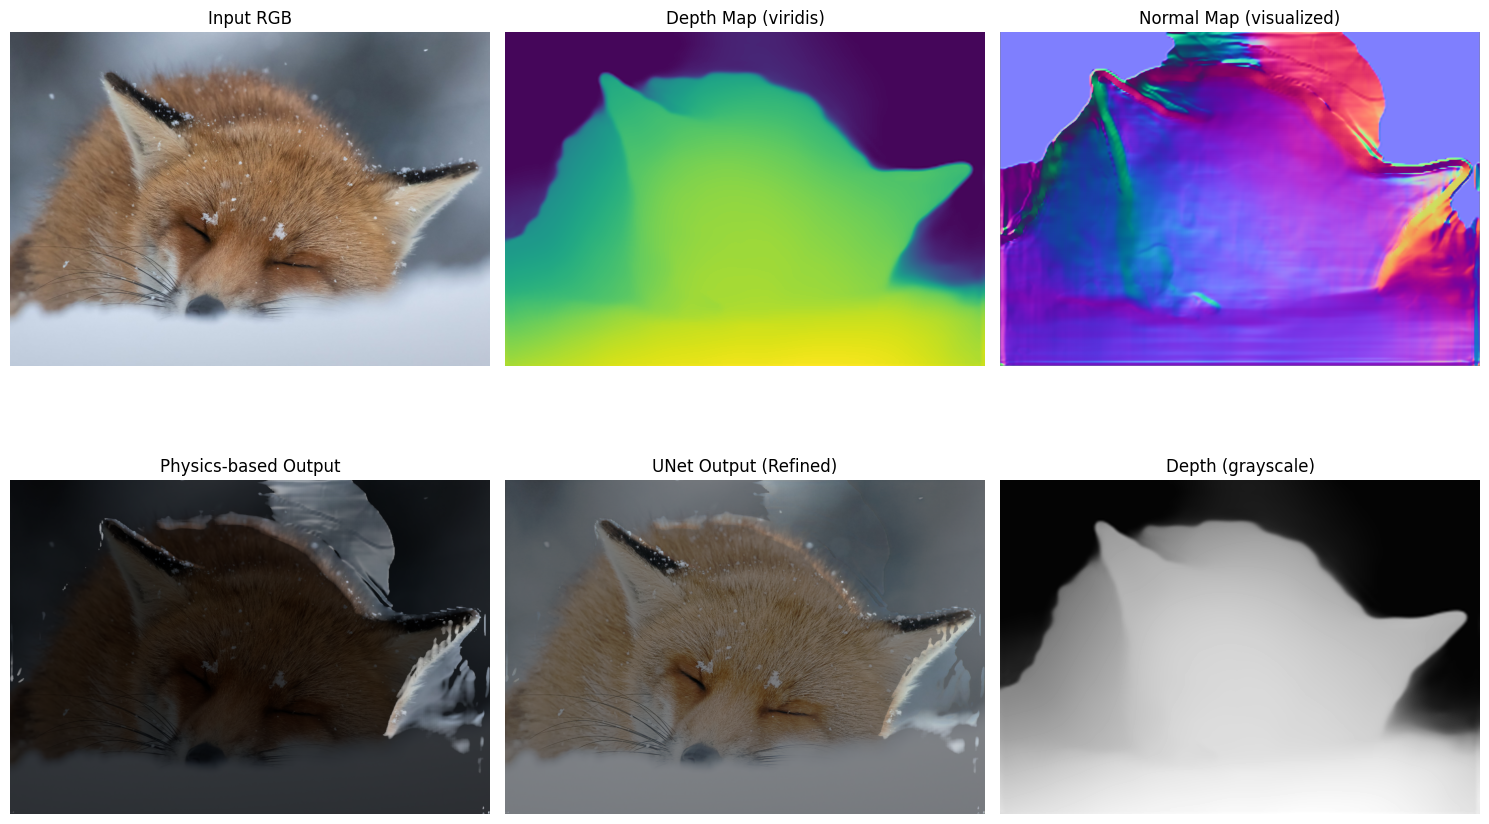

In [11]:
import os
import cv2
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1) Load trained model
# ---------------------------
CKPT_PATH = "/kaggle/input/relightnet-midas/pytorch/default/1/relightnet_midas_epoch5.pth"  # your path

model = TinyRelightNet(in_ch=10, base_ch=32).to(device)

state = torch.load(CKPT_PATH, map_location=device)
if isinstance(state, dict) and "model" in state:
    model.load_state_dict(state["model"])
else:
    model.load_state_dict(state)

model.eval()
print(f"Loaded weights from: {CKPT_PATH}")

# ---------------------------
# 2) Load MiDaS
# ---------------------------
midas, midas_transforms = load_midas(device)
print("MiDaS loaded.")

# ---------------------------
# 3) Helper: make H,W divisible by 8
# ---------------------------
def make_divisible_hw(H, W, divisor=8):
    new_H = int(math.ceil(H / divisor) * divisor)
    new_W = int(math.ceil(W / divisor) * divisor)
    return new_H, new_W

# ---------------------------
# 4) Full pipeline on a (possibly resized) image
# ---------------------------
def run_full_pipeline(img_bgr_orig, start_pt, end_pt, intensity=1.0):
    """
    img_bgr_orig : H,W,3 uint8 (original image read by cv2)
    start_pt, end_pt : swipe points in ORIGINAL pixel coords
    intensity : scalar for light intensity

    Returns:
        input_rgb_vis   : H0,W0,3 [0,1]       (resized back to original)
        depth_vis       : H0,W0   [0,1]
        normals_vis_rgb : H0,W0,3 [0,1]       (mapped from [-1,1] to [0,1])
        physics_vis     : H0,W0,3 [0,1]
        unet_out_vis    : H0,W0,3 [0,1]
    """
    H0, W0 = img_bgr_orig.shape[:2]

    # --- Resize image to be divisible by 8 for U-Net ---
    H_res, W_res = make_divisible_hw(H0, W0, divisor=8)
    img_bgr = cv2.resize(img_bgr_orig, (W_res, H_res), interpolation=cv2.INTER_AREA)

    # Also scale gesture points to the resized image coordinates
    sx, sy = start_pt
    ex, ey = end_pt
    sx_res = int(sx * (W_res / W0))
    ex_res = int(ex * (W_res / W0))
    sy_res = int(sy * (H_res / H0))
    ey_res = int(ey * (H_res / H0))

    # ----- Input RGB -----
    input_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0  # H_res,W_res,3

    # ----- Depth (MiDaS works on this resized BGR) -----
    depth = get_depth_from_midas_bgr(img_bgr, midas, midas_transforms, device)  # H_res,W_res
    depth_s = smooth_depth(depth)

    # ----- Normals -----
    normals = depth_to_normals_intrinsic(depth_s)  # H_res,W_res,3 in [-1,1]

    # ----- Light from gesture (on resized dims) -----
    light_vec = swipe_to_direction((sx_res, sy_res), (ex_res, ey_res), (H_res, W_res))

    # ----- Physics-based relight -----
    physics_img = physics_relight(
        input_rgb_srgb=input_rgb,
        depth=depth_s,
        normals=normals,
        light_vec=light_vec,
        is_point=False,
        light_pos=None,
        intensity=float(intensity),
    )  # H_res,W_res,3 [0,1]

    # ----- Build net input -----
    inp_chw     = np.transpose(input_rgb,    (2, 0, 1))  # 3,H_res,W_res
    phys_chw    = np.transpose(physics_img,  (2, 0, 1))  # 3,H_res,W_res
    normals_chw = np.transpose(normals,      (2, 0, 1))  # 3,H_res,W_res
    depth_chw   = depth_s[None, ...]                      # 1,H_res,W_res

    net_in_np = np.concatenate([inp_chw, phys_chw, normals_chw, depth_chw], axis=0)  # 10,H_res,W_res
    net_in = torch.from_numpy(net_in_np).unsqueeze(0).float().to(device)             # 1,10,H_res,W_res

    lx, ly, lz = light_vec.tolist()
    light_cond = torch.tensor([[lx, ly, lz, float(intensity)]], dtype=torch.float32).to(device)  # 1,4

    phys_t = torch.from_numpy(phys_chw).unsqueeze(0).to(device)  # 1,3,H_res,W_res

    # ----- UNet forward (residual + physics, same as training) -----
    with torch.no_grad():
        residual = model(net_in, light_cond)  # 1,3,H_res,W_res in [0,1]
        out = torch.clamp(phys_t + (residual - 0.5) * 0.6, 0.0, 1.0)

    unet_out = out[0].cpu().numpy().transpose(1, 2, 0)  # H_res,W_res,3 [0,1]

    # ----- Resize everything back to original H0,W0 for visualization -----
    input_rgb_vis = cv2.resize(input_rgb,   (W0, H0), interpolation=cv2.INTER_LINEAR)
    depth_vis     = cv2.resize(depth_s,     (W0, H0), interpolation=cv2.INTER_LINEAR)
    normals_vis   = cv2.resize(normals,     (W0, H0), interpolation=cv2.INTER_LINEAR)
    physics_vis   = cv2.resize(physics_img, (W0, H0), interpolation=cv2.INTER_LINEAR)
    unet_out_vis  = cv2.resize(unet_out,    (W0, H0), interpolation=cv2.INTER_LINEAR)

    # Map normals from [-1,1] → [0,1] for display
    normals_vis_rgb = (normals_vis * 0.5 + 0.5).clip(0, 1)

    return input_rgb_vis, depth_vis, normals_vis_rgb, physics_vis, unet_out_vis


# ---------------------------
# 5) Visualize everything
# ---------------------------
IMAGE_PATH = "/kaggle/input/sample/Screenshot 2024-06-23 080042.png"  # <-- change this

img_bgr0 = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if img_bgr0 is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}")

H0, W0 = img_bgr0.shape[:2]

# Swipe in ORIGINAL coordinates (we'll internally scale them)
start_pt = (int(0.1 * W0), H0 // 2)   # e.g., left-middle
end_pt   = (int(0.9 * W0), H0 // 2)   # right-middle
intensity = 1.2

input_rgb, depth_s, normals_vis, physics_img, unet_out = run_full_pipeline(
    img_bgr0, start_pt, end_pt, intensity=intensity
)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Input RGB")
plt.imshow(input_rgb)
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Depth Map (viridis)")
plt.imshow(depth_s, cmap="viridis")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Normal Map (visualized)")
plt.imshow(normals_vis)
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Physics-based Output")
plt.imshow(physics_img)
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("UNet Output (Refined)")
plt.imshow(unet_out)
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Depth (grayscale)")
plt.imshow(depth_s, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

**Swipe based Inference**

Image loaded: /kaggle/input/sample/Screenshot 2024-06-23 080042.png Shape: (848, 1217, 3)
Using light vector: [ 0.         -0.99995005 -0.0099995 ]
Using intensity: 2.2


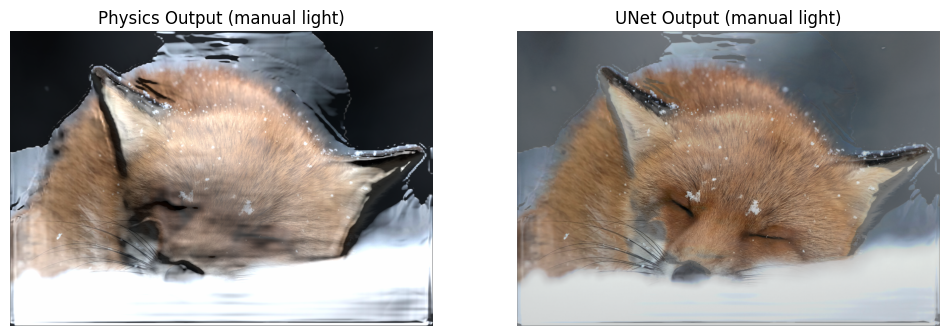

In [24]:
import math

# ---------- choose input image ----------
IMAGE_PATH = "/kaggle/input/sample/Screenshot 2024-06-23 080042.png"  # <- change if you want
img_bgr0 = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if img_bgr0 is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}")

H0, W0 = img_bgr0.shape[:2]
print("Image loaded:", IMAGE_PATH, "Shape:", img_bgr0.shape)

# ---------- helper: make H,W divisible by 8 ----------
def make_divisible_hw(H, W, divisor=8):
    new_H = int(math.ceil(H / divisor) * divisor)
    new_W = int(math.ceil(W / divisor) * divisor)
    return new_H, new_W

# ---------- 1) choose intensity ----------
intensity = 2.2   # <--- you can change this (0.2–2.0)

# ---------- 2) choose light direction (raw_vec) ----------
# [1, 0, -1]   → from right
# [-1, 0, -1]  → from left
# [0, -1, -1]  → from top
# [0, 1, -1]   → from bottom
# [1, 1, -1]   → from bottom-right, etc.
raw_vec = np.array([0, -1, -0.01], dtype=np.float32)  # <--- edit this
light_vec = raw_vec / (np.linalg.norm(raw_vec) + 1e-9)

print("Using light vector:", light_vec)
print("Using intensity:", intensity)

# ---------- 3) full pipeline at resized resolution ----------
# resize image to be friendly for UNet
H_res, W_res = make_divisible_hw(H0, W0, divisor=8)
img_bgr = cv2.resize(img_bgr0, (W_res, H_res), interpolation=cv2.INTER_AREA)

# RGB [0,1]
input_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

# depth from MiDaS on resized image
depth = get_depth_from_midas_bgr(img_bgr, midas, midas_transforms, device)
depth_s = smooth_depth(depth)

# normals from depth
normals = depth_to_normals_intrinsic(depth_s)  # H_res,W_res,3 in [-1,1]

# physics relight with MANUAL light_vec
physics_manual = physics_relight(
    input_rgb_srgb=input_rgb,
    depth=depth_s,
    normals=normals,
    light_vec=light_vec,
    is_point=False,
    light_pos=None,
    intensity=float(intensity),
)

# build 10ch input
inp_chw     = np.transpose(input_rgb,       (2, 0, 1))   # 3,H_res,W_res
phys_chw    = np.transpose(physics_manual,  (2, 0, 1))   # 3,H_res,W_res
normals_chw = np.transpose(normals,         (2, 0, 1))   # 3,H_res,W_res
depth_chw   = depth_s[None, ...]                          # 1,H_res,W_res

net_in_np = np.concatenate([inp_chw, phys_chw, normals_chw, depth_chw], axis=0)
net_in = torch.from_numpy(net_in_np).unsqueeze(0).float().to(device)

# light condition
lx, ly, lz = light_vec.tolist()
light_cond = torch.tensor([[lx, ly, lz, intensity]], dtype=torch.float32).to(device)

phys_t = torch.from_numpy(phys_chw).unsqueeze(0).to(device)

with torch.no_grad():
    residual = model(net_in, light_cond)            # 1,3,H_res,W_res
    out_manual = torch.clamp(phys_t + (residual - 0.5) * 0.6, 0.0, 1.0)

out_manual = out_manual[0].cpu().numpy().transpose(1, 2, 0)  # H_res,W_res,3

# ---------- 4) resize outputs back to original for display ----------
physics_vis = cv2.resize(physics_manual, (W0, H0), interpolation=cv2.INTER_LINEAR)
unet_vis    = cv2.resize(out_manual,     (W0, H0), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Physics Output (manual light)"); plt.imshow(physics_vis); plt.axis("off")
plt.subplot(1,2,2); plt.title("UNet Output (manual light)");    plt.imshow(unet_vis);    plt.axis("off")
plt.show()

**Tap based Inference**

Image loaded: /kaggle/input/sample/Screenshot 2024-06-23 080042.png Shape: (848, 1217, 3)
Tap point (orig): (608, 254), z_offset=-1, intensity=2
3D light_pos (x,y,z): (611.0, 254.0, -0.2508138418197632)


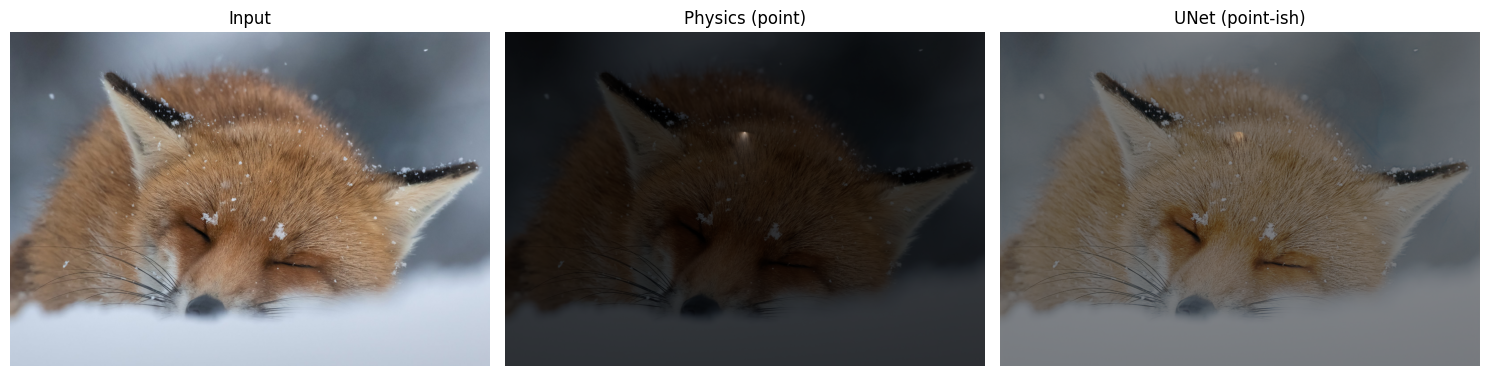

In [14]:
import math

# ---------------------------
# 0) load image
# ---------------------------
IMAGE_PATH = "/kaggle/input/sample/Screenshot 2024-06-23 080042.png"  # change if needed
img_bgr0 = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if img_bgr0 is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}")
H0, W0 = img_bgr0.shape[:2]
print("Image loaded:", IMAGE_PATH, "Shape:", img_bgr0.shape)

# ---------------------------
# helpers
# ---------------------------
def make_divisible_hw(H, W, divisor=8):
    new_H = int(math.ceil(H / divisor) * divisor)
    new_W = int(math.ceil(W / divisor) * divisor)
    return new_H, new_W

# ---------------------------
# 1) choose point, z_offset & intensity
# ---------------------------
# tap in ORIGINAL image coordinates:
tap_x = int(W0 * 0.5)  # center
tap_y = int(H0 * 0.3)  # near top third
tap_pt_orig = (tap_x, tap_y)

z_offset = -1   # +ve: move light further "out of surface", -ve: more inside
intensity = 2  # brightness scale

print(f"Tap point (orig): {tap_pt_orig}, z_offset={z_offset}, intensity={intensity}")

# ---------------------------
# 2) resize image for UNet
# ---------------------------
H_res, W_res = make_divisible_hw(H0, W0, divisor=8)
img_bgr = cv2.resize(img_bgr0, (W_res, H_res), interpolation=cv2.INTER_AREA)

# scale tap point into resized coordinates
tap_x_res = int(tap_x * (W_res / W0))
tap_y_res = int(tap_y * (H_res / H0))
tap_pt_res = (tap_x_res, tap_y_res)

# ---------------------------
# 3) compute depth & normals
# ---------------------------
input_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

depth = get_depth_from_midas_bgr(img_bgr, midas, midas_transforms, device)  # H_res,W_res
depth_s = smooth_depth(depth)
normals = depth_to_normals_intrinsic(depth_s)  # H_res,W_res,3

# ---------------------------
# 4) construct point light in 3D
# ---------------------------
# tap_to_point_light uses normalized depth_map to get base_z,
# then adds z_offset
light_pos = tap_to_point_light(tap_pt_res, depth_s, z_offset=z_offset)
print("3D light_pos (x,y,z):", light_pos)

# ---------------------------
# 5) physics-based point-light relight
# ---------------------------
physics_point = physics_relight(
    input_rgb_srgb=input_rgb,
    depth=depth_s,
    normals=normals,
    light_vec=None,          # not used when is_point=True
    light_color=(1.0, 1.0, 1.0),
    is_point=True,
    light_pos=light_pos,
    kd=1.0,
    ks=0.2,
    shininess=32.0,
    ambient=0.05,
    intensity=float(intensity),
)

# ---------------------------
# 6) build 10-channel input & light_cond for UNet
# ---------------------------
inp_chw     = np.transpose(input_rgb,     (2, 0, 1))   # 3,H_res,W_res
phys_chw    = np.transpose(physics_point, (2, 0, 1))   # 3,H_res,W_res
normals_chw = np.transpose(normals,       (2, 0, 1))   # 3,H_res,W_res
depth_chw   = depth_s[None, ...]                        # 1,H_res,W_res

net_in_np = np.concatenate([inp_chw, phys_chw, normals_chw, depth_chw], axis=0)
net_in = torch.from_numpy(net_in_np).unsqueeze(0).float().to(device)

# for FiLM we still need some 4D condition; we can use:
# direction from center pixel to light + intensity
cx, cy = W_res * 0.5, H_res * 0.5
cz = float(depth_s[int(H_res*0.5), int(W_res*0.5)])
center_pos = np.array([cx, cy, cz], dtype=np.float32)
L_dir = np.array(light_pos, dtype=np.float32) - center_pos
L_dir /= (np.linalg.norm(L_dir) + 1e-9)

lx, ly, lz = L_dir.tolist()
light_cond = torch.tensor([[lx, ly, lz, float(intensity)]], dtype=torch.float32).to(device)

phys_t = torch.from_numpy(phys_chw).unsqueeze(0).to(device)

with torch.no_grad():
    residual = model(net_in, light_cond)
    out_point = torch.clamp(phys_t + (residual - 0.5) * 0.6, 0.0, 1.0)

out_point = out_point[0].cpu().numpy().transpose(1, 2, 0)  # H_res,W_res,3

# ---------------------------
# 7) resize results back to original & visualize
# ---------------------------
physics_vis = cv2.resize(physics_point, (W0, H0), interpolation=cv2.INTER_LINEAR)
unet_vis    = cv2.resize(out_point,     (W0, H0), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Input");        plt.imshow(cv2.cvtColor(img_bgr0, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Physics (point)"); plt.imshow(physics_vis); plt.axis("off")
plt.subplot(1,3,3); plt.title("UNet (point-ish)");  plt.imshow(unet_vis);    plt.axis("off")
plt.tight_layout()
plt.show()